In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


# Load inhibition data 

In [3]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainX.csv")
train_y_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainY.csv")
test_x_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testX.csv")
test_y_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testY.csv")
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


In [4]:
# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.946, precision: 0.625, recall: 0.536, sensitivity: 0.536, specificity: 0.976


<Axes: title={'center': 'NEK2 Inhib Test: Basic RF'}, xlabel='Predicted label', ylabel='True label'>

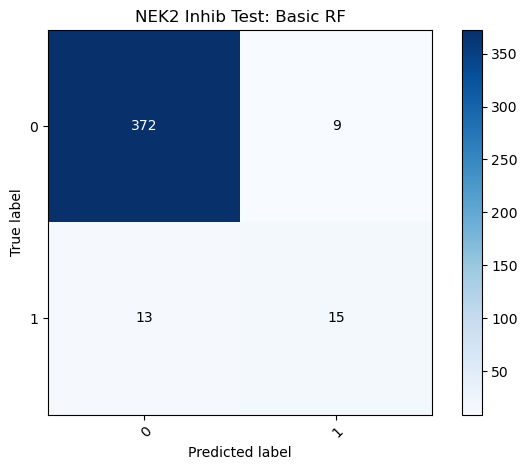

In [5]:
rf_basic100est = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, rf_basic100est['test_pred'], ['0','1'], title='NEK2 Inhib Test: Basic RF')

In [7]:
max_depths = [20,50,100]
n_estimators = [100,200,500]
max_features = [50,100,300]

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.915, precision: 0.125, recall: 0.167, sensitivity: 0.167, specificity: 0.948
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.905, precision: 0.105, recall: 0.167, sensitivity: 0.167, specificity: 0.937
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.908, precision: 0.111, recall: 0.167, sensitivity: 0.167, specificity: 0.941


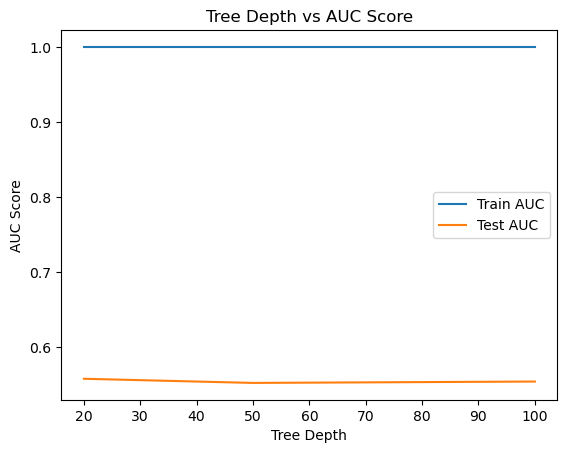

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.118, recall: 0.167, sensitivity: 0.167, specificity: 0.945
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.912, precision: 0.118, recall: 0.167, sensitivity: 0.167, specificity: 0.945
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.908, precision: 0.111, recall: 0.167, sensitivity: 0.167, specificity: 0.941


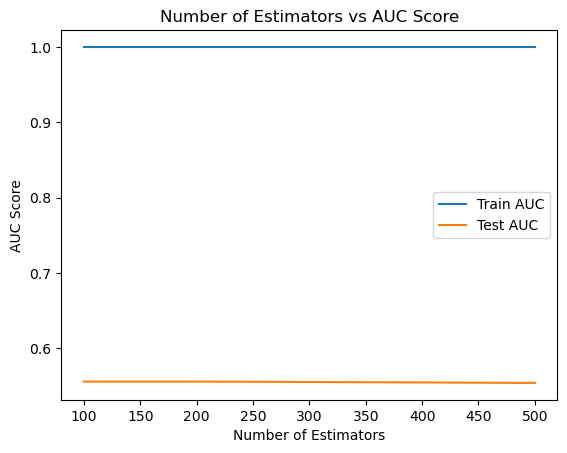

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.958, precision: 0.500, recall: 0.083, sensitivity: 0.083, specificity: 0.996
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.958, precision: 0.500, recall: 0.083, sensitivity: 0.083, specificity: 0.996


In [ ]:

rf_plots(train_x, train_y, test_x, test_y, max_depths, n_estimators, max_features, 'basic RF', parameters={}, dataset_type='inhibition')

# Reduced param grid for grid search - RUN IN BASH SCRIPT 

In [ ]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [ ]:
# save_file = 'atom_nek2inhib_rf_basic_best.pkl'
# rf_basicbest = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  save_file, 2)
# save_model(rf_basicbest['best_model'], save_file)

In [ ]:
with open(save_file, 'rb') as f: 
    rf_basicbest = pickle.load(f) 


# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.932, precision: 0.500, recall: 0.500, sensitivity: 0.500, specificity: 0.963


<Axes: title={'center': 'NEK2 inhib Test: RF + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

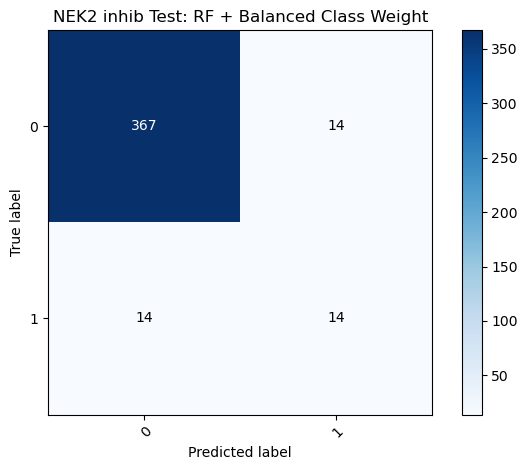

In [6]:
brf_model_BCW = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_model_BCW['test_pred'], ['0','1'], title='NEK2 inhib Test: RF + Balanced Class Weight')

In [ ]:
save_file2 = 'atom_nek2inhibition_rf_basicBCW_best.pkl'
# rf_basicBCWbest = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid,  save_file2, 2)
# save_model(rf_basicBCWbest['best_model'], save_file2)

with open(save_file2, 'rb') as f: 
    rf_basicBCWbest = pickle.load(f) 


# Balanced Random Forest Classifier

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.946, precision: 0.636, recall: 0.500, sensitivity: 0.500, specificity: 0.979


<Axes: title={'center': 'NEK2 Inhib Test: Balanced RFC'}, xlabel='Predicted label', ylabel='True label'>

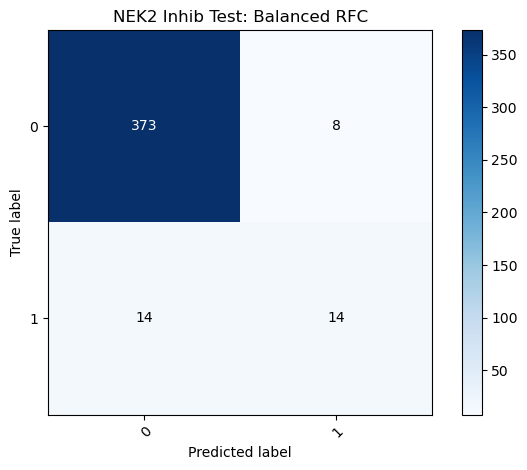

In [7]:
brf_model = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_model['test_pred'], ['0','1'], title='NEK2 Inhib Test: Balanced RFC')

In [ ]:
save_file3 = 'atom_nek2inhib_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {}, param_grid,  save_file3, 2)
# save_model(brfc_best['best_model'], save_file3)
with open(save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 


# Try BRFC with balanced class weight & bootstrap

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, sensitivity: 1.000, specificity: 1.000
TEST: accuracy: 0.934, precision: 0.519, recall: 0.500, sensitivity: 0.500, specificity: 0.966


<Axes: title={'center': 'NEK2 Inhib Test: Balanced RFC + Balanced Class Weight'}, xlabel='Predicted label', ylabel='True label'>

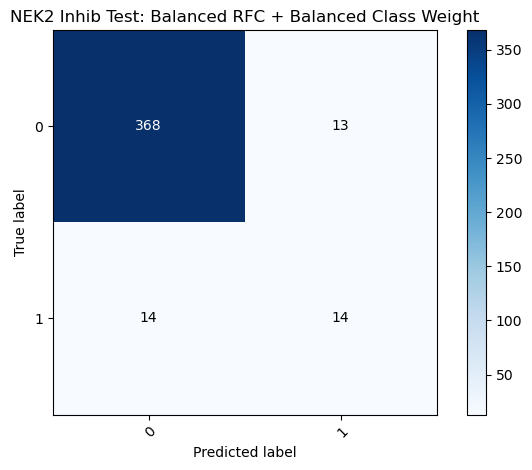

In [8]:
brf_modelCWB = rf_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, 'inhibition')
# plot_confusion_matrix(train_y, rf_basic100est['train_pred'], ['0','1'], title='NEK2 Binding Train: Basic RF')
plot_confusion_matrix(test_y, brf_modelCWB['test_pred'], ['0','1'], title='NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [ ]:
save_file4 = 'atom_nek2inhib_BRFC_BCW_best.pkl'
# brfc_BCW_best = find_best_models(train_x, train_y, test_x, test_y, 'BalancedRandomForestClassifier', {'class_weight':'balanced', 'bootstrape':'True'}, param_grid,  save_file4, 2)
# save_model(brfc_BCW_best['best_model'], save_file4)
with open(save_file4, 'rb') as f: 
    brfc_BCW_best = pickle.load(f) 


In [ ]:
# max depth was default 1-- 
